In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print("=" * 70)
print("РЕГРЕССИОННЫЙ АНАЛИЗ")
print("ПРЕДСКАЗАНИЕ ЦЕН НЕДВИЖИМОСТИ")
print("=" * 70)

РЕГРЕССИОННЫЙ АНАЛИЗ
ПРЕДСКАЗАНИЕ ЦЕН НЕДВИЖИМОСТИ


In [35]:
print("\n1. ЗАГРУЗКА ДАННЫХ...")

# Список признаков из задания
columns = [
    'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
    'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
    'school_education_centers_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'sport_objects_raion',
    'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk',
    'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km',
    'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'ts_km', 'big_market_km', 'market_shop_km',
    'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km',
    'additional_education_raion', 'preschool_km', 'price_doc'
]

try:
    # Загружаем данные из train.csv
    df = pd.read_csv('train.csv', usecols=columns)
    print(f"✓ Данные загружены из train.csv")
    print(f"Размер данных: {df.shape}")

except FileNotFoundError:
    print("❌ Файл train.csv не найден!")
    print("Убедитесь, что файл загружен в Colab:")
    print("1. В левой панели нажмите 📁 Files")
    print("2. Нажмите 'Upload to session storage'")
    print("3. Выберите train.csv")
    print("4. Перезапустите код")
    raise


1. ЗАГРУЗКА ДАННЫХ...
✓ Данные загружены из train.csv
Размер данных: (11639, 44)



2. ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11639 entries, 0 to 11638
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   full_sq                            11639 non-null  int64  
 1   life_sq                            9031 non-null   float64
 2   floor                              11472 non-null  float64
 3   max_floor                          2067 non-null   float64
 4   material                           2067 non-null   float64
 5   build_year                         1661 non-null   float64
 6   num_room                           2067 non-null   float64
 7   kitch_sq                           2067 non-null   float64
 8   state                              1605 non-null   float64
 9   area_m                             11639 non-null  float64
 10  raion_popul                        11639 non-null  int64  
 11

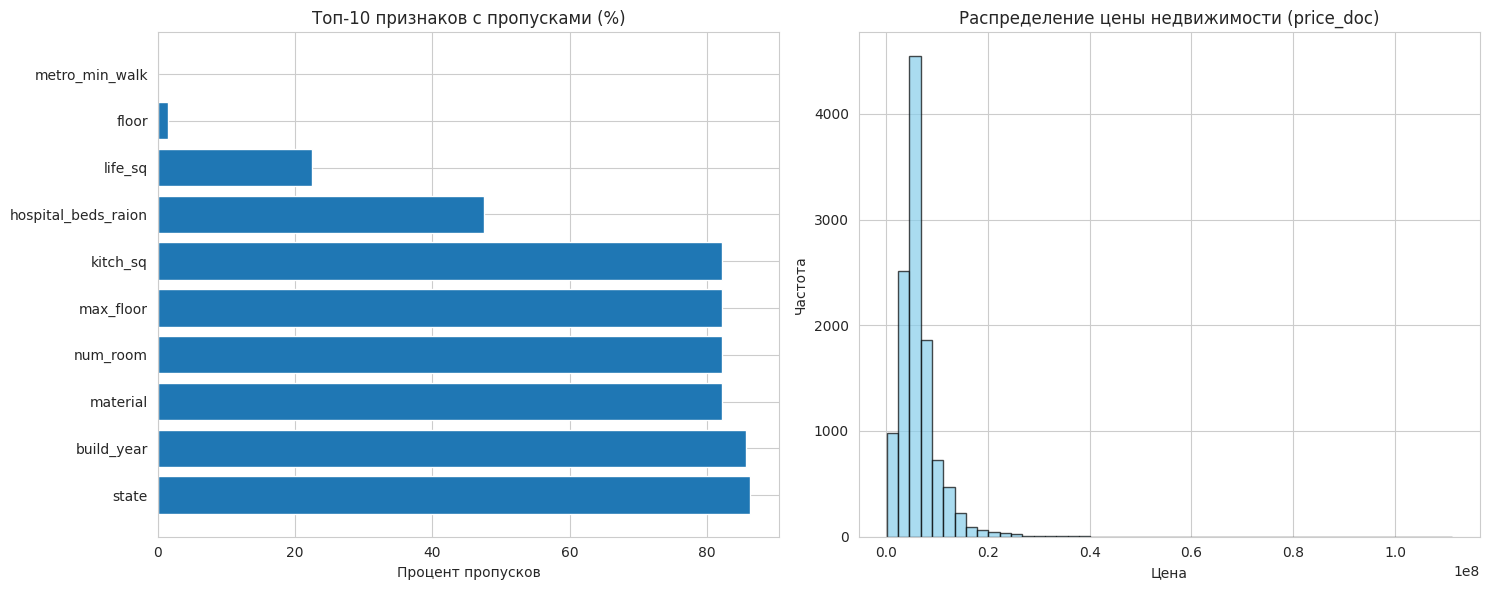

In [36]:
print("\n" + "="*50)
print("2. ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)")
print("="*50)

# Базовая информация о данных
print("\nИнформация о данных:")
print(df.info())

print("\nСтатистическое описание числовых признаков:")
print(df.describe())

# Анализ пропущенных значений
print("\nАНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({
    'Пропусков': missing_data,
    'Процент': missing_percent
})

# Показываем только признаки с пропусками
missing_with_gaps = missing_info[missing_info['Пропусков'] > 0]
if len(missing_with_gaps) > 0:
    print("Признаки с пропусками:")
    print(missing_with_gaps.sort_values('Процент', ascending=False))
else:
    print("✓ Пропущенных значений не обнаружено")

# Визуализация пропусков и распределения целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# График пропусков (если есть)
if len(missing_with_gaps) > 0:
    missing_plot_data = missing_with_gaps.sort_values('Процент', ascending=False).head(10)
    axes[0].barh(missing_plot_data.index, missing_plot_data['Процент'])
    axes[0].set_title('Топ-10 признаков с пропусками (%)')
    axes[0].set_xlabel('Процент пропусков')
else:
    axes[0].text(0.5, 0.5, 'Пропусков нет', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Пропущенные значения')

# Распределение целевой переменной
axes[1].hist(df['price_doc'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_title('Распределение цены недвижимости (price_doc)')
axes[1].set_xlabel('Цена')
axes[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()


3. АНАЛИЗ ВЫБРОСОВ
АНАЛИЗ ВЫБРОСОВ В КЛЮЧЕВЫХ ПРИЗНАКАХ:
full_sq: 393 выбросов (3.38%)
life_sq: 323 выбросов (2.78%)
kitch_sq: 12 выбросов (0.10%)
floor: 237 выбросов (2.04%)
price_doc: 788 выбросов (6.77%)


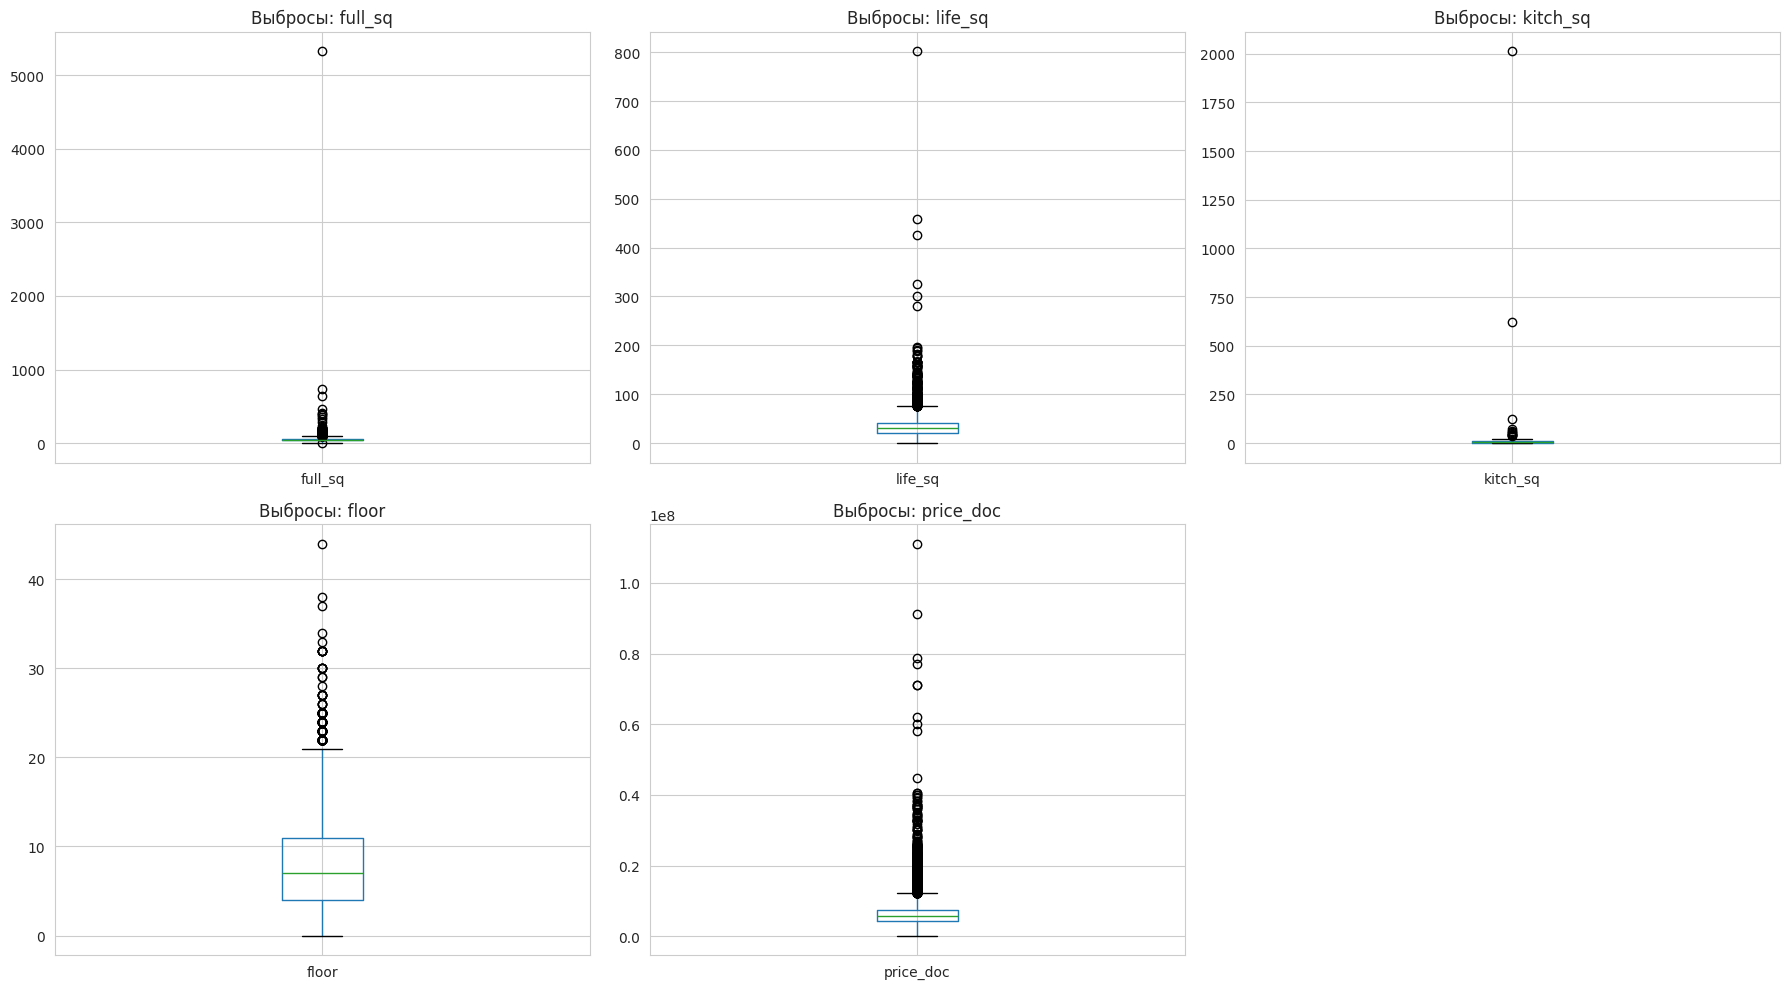

In [37]:
print("\n" + "="*50)
print("3. АНАЛИЗ ВЫБРОСОВ")
print("="*50)

# Функция для определения выбросов по IQR
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Анализ выбросов в ключевых признаках
key_features = ['full_sq', 'life_sq', 'kitch_sq', 'floor', 'price_doc']
outliers_info = {}

print("АНАЛИЗ ВЫБРОСОВ В КЛЮЧЕВЫХ ПРИЗНАКАХ:")
for feature in key_features:
    if feature in df.columns:
        outliers, lower, upper = detect_outliers_iqr(df[feature])
        outliers_info[feature] = {
            'outliers_count': len(outliers),
            'outliers_percent': (len(outliers) / len(df)) * 100,
            'lower_bound': lower,
            'upper_bound': upper
        }
        print(f"{feature}: {len(outliers)} выбросов ({outliers_info[feature]['outliers_percent']:.2f}%)")

# Визуализация выбросов
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features[:6]):  # Первые 6 признаков
    if i < len(axes) and feature in df.columns:
        df.boxplot(column=feature, ax=axes[i])
        axes[i].set_title(f'Выбросы: {feature}')

# Убираем лишние subplots
for i in range(len(key_features[:6]), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [38]:
print("\n" + "="*50)
print("4. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ")
print("="*50)

# Функция для оценки модели
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print()

    return {'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Подготовка данных для моделирования
X = df.drop('price_doc', axis=1)
y = df['price_doc']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Инициализация инструментов
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Список для хранения результатов
results = []


4. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ
Обучающая выборка: (9311, 43)
Тестовая выборка: (2328, 43)


In [40]:
print("\n" + "="*50)
print("5. ПОСТЕПЕННОЕ ОБУЧЕНИЕ МОДЕЛИ")
print("="*50)

# Очистим данные от NaN перед началом обучения
print("Очистка данных от NaN...")

# Удаляем строки с NaN в целевой переменной
nan_mask = y_train.isna()
if nan_mask.any():
    print(f"Удалено {nan_mask.sum()} строк с NaN в y_train")
    X_train = X_train.loc[~nan_mask]
    y_train = y_train.loc[~nan_mask]

# Также проверяем тестовую выборку
nan_mask_test = y_test.isna()
if nan_mask_test.any():
    print(f"Удалено {nan_mask_test.sum()} строк с NaN в y_test")
    X_test = X_test.loc[~nan_mask_test]
    y_test = y_test.loc[~nan_mask_test]

# Сбрасываем индексы после очистки
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Размеры после очистки: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"NaN в y_train: {y_train.isna().sum()}, NaN в y_test: {y_test.isna().sum()}")

# Итерация 1: Базовая модель (без обработки выбросов)
print("\n" + "="*50)
print("ИТЕРАЦИЯ 1: БАЗОВАЯ МОДЕЛЬ (без обработки)")
print("="*50)

# Заполнение пропусков средним значением
X_train_base = imputer.fit_transform(X_train)
X_test_base = imputer.transform(X_test)

# Масштабирование
X_train_scaled = scaler.fit_transform(X_train_base)
X_test_scaled = scaler.transform(X_test_base)

# Обучение модели
model_v1 = LinearRegression()
model_v1.fit(X_train_scaled, y_train)

# Предсказание и оценка
y_pred_v1 = model_v1.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_v1, "Модель v1 (базовая)"))

# Итерация 2: Обработка выбросов в full_sq
print("="*50)
print("ИТЕРАЦИЯ 2: ОБРАБОТКА ВЫБРОСОВ В full_sq")
print("="*50)

# Копируем данные
X_train_v2 = X_train.copy()
X_test_v2 = X_test.copy()

# Обрабатываем выбросы в full_sq
if 'full_sq' in X_train_v2.columns:
    outliers_full_sq, lower_fs, upper_fs = detect_outliers_iqr(X_train_v2['full_sq'])
    print(f"Обнаружено выбросов в full_sq: {len(outliers_full_sq)}")

    # Заменяем выбросы граничными значениями
    X_train_v2['full_sq'] = np.where(
        X_train_v2['full_sq'] > upper_fs, upper_fs, X_train_v2['full_sq']
    )
    X_test_v2['full_sq'] = np.where(
        X_test_v2['full_sq'] > upper_fs, upper_fs, X_test_v2['full_sq']
    )

# Заполнение пропусков и масштабирование
X_train_v2_imp = imputer.fit_transform(X_train_v2)
X_test_v2_imp = imputer.transform(X_test_v2)

X_train_v2_scaled = scaler.fit_transform(X_train_v2_imp)
X_test_v2_scaled = scaler.transform(X_test_v2_imp)

# Обучение модели
model_v2 = LinearRegression()
model_v2.fit(X_train_v2_scaled, y_train)

y_pred_v2 = model_v2.predict(X_test_v2_scaled)
results.append(evaluate_model(y_test, y_pred_v2, "Модель v2 (обработан full_sq)"))

# Итерация 3: Обработка выбросов в life_sq
print("="*50)
print("ИТЕРАЦИЯ 3: ОБРАБОТКА ВЫБРОСОВ В life_sq")
print("="*50)

X_train_v3 = X_train_v2.copy()
X_test_v3 = X_test_v2.copy()

# Обработка life_sq
if 'life_sq' in X_train_v3.columns:
    outliers_life_sq, lower_ls, upper_ls = detect_outliers_iqr(X_train_v3['life_sq'])
    print(f"Обнаружено выбросов в life_sq: {len(outliers_life_sq)}")

    X_train_v3['life_sq'] = np.where(
        X_train_v3['life_sq'] > upper_ls, upper_ls, X_train_v3['life_sq']
    )
    X_test_v3['life_sq'] = np.where(
        X_test_v3['life_sq'] > upper_ls, upper_ls, X_test_v3['life_sq']
    )

# Обучение модели
X_train_v3_imp = imputer.fit_transform(X_train_v3)
X_test_v3_imp = imputer.transform(X_test_v3)

X_train_v3_scaled = scaler.fit_transform(X_train_v3_imp)
X_test_v3_scaled = scaler.transform(X_test_v3_imp)

model_v3 = LinearRegression()
model_v3.fit(X_train_v3_scaled, y_train)

y_pred_v3 = model_v3.predict(X_test_v3_scaled)
results.append(evaluate_model(y_test, y_pred_v3, "Модель v3 (обработан life_sq)"))


5. ПОСТЕПЕННОЕ ОБУЧЕНИЕ МОДЕЛИ
Очистка данных от NaN...
Удалено 1 строк с NaN в y_train
Размеры после очистки: X_train (9310, 43), y_train (9310,)
NaN в y_train: 0, NaN в y_test: 0

ИТЕРАЦИЯ 1: БАЗОВАЯ МОДЕЛЬ (без обработки)
Модель v1 (базовая):
  MSE: 80471573215561.66
  RMSE: 8970594.92
  R²: -3.1785

ИТЕРАЦИЯ 2: ОБРАБОТКА ВЫБРОСОВ В full_sq
Обнаружено выбросов в full_sq: 316
Модель v2 (обработан full_sq):
  MSE: 10188946443708.17
  RMSE: 3192012.91
  R²: 0.4709

ИТЕРАЦИЯ 3: ОБРАБОТКА ВЫБРОСОВ В life_sq
Обнаружено выбросов в life_sq: 247
Модель v3 (обработан life_sq):
  MSE: 10360912488607.08
  RMSE: 3218837.13
  R²: 0.4620



In [42]:
print("\n" + "="*50)
print("6. ГЕНЕРАЦИЯ НОВЫХ ПРИЗНАКОВ")
print("="*50)

# Начинаем с обработанных данных
X_train_current = X_train_v3.copy()
X_test_current = X_test_v3.copy()

print("Начальная размерность:", X_train_current.shape)

# Упрощенная функция для добавления признаков
def add_feature_and_evaluate_simple(X_train_current, X_test_current, feature_name,
                                   new_feature_train, new_feature_test, model_name):
    """Добавляет новый признак и оценивает модель"""

    # Добавляем новый признак
    X_train_new = X_train_current.copy()
    X_test_new = X_test_current.copy()

    X_train_new[feature_name] = new_feature_train
    X_test_new[feature_name] = new_feature_test

    # Заполняем возможные NaN
    X_train_new = X_train_new.fillna(0)
    X_test_new = X_test_new.fillna(0)

    # Масштабирование
    X_train_scaled = scaler.fit_transform(X_train_new)
    X_test_scaled = scaler.transform(X_test_new)

    # Обучение модели
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Предсказание и оценка
    y_pred = model.predict(X_test_scaled)
    return evaluate_model(y_test, y_pred, model_name), X_train_new, X_test_new

# ПРИЗНАК 1: Соотношение жилой и общей площади
print("\n--- ПРИЗНАК 1: Соотношение living_ratio ---")
if 'life_sq' in X_train_current.columns and 'full_sq' in X_train_current.columns:
    living_ratio_train = X_train_current['life_sq'] / (X_train_current['full_sq'] + 1e-8)
    living_ratio_test = X_test_current['life_sq'] / (X_test_current['full_sq'] + 1e-8)

    # Заменяем бесконечности и NaN на 0
    living_ratio_train = living_ratio_train.replace([np.inf, -np.inf, np.nan], 0)
    living_ratio_test = living_ratio_test.replace([np.inf, -np.inf, np.nan], 0)

    result_v4, X_train_v4, X_test_v4 = add_feature_and_evaluate_simple(
        X_train_current, X_test_current, 'living_ratio',
        living_ratio_train, living_ratio_test, "Модель v4 (+living_ratio)"
    )
    results.append(result_v4)
    X_train_current, X_test_current = X_train_v4, X_test_v4

# ПРИЗНАК 2: Площадь кухни относительно общей
print("\n--- ПРИЗНАК 2: Соотношение kitchen_ratio ---")
if 'kitch_sq' in X_train_current.columns and 'full_sq' in X_train_current.columns:
    kitchen_ratio_train = X_train_current['kitch_sq'] / (X_train_current['full_sq'] + 1e-8)
    kitchen_ratio_test = X_test_current['kitch_sq'] / (X_test_current['full_sq'] + 1e-8)

    # Заменяем бесконечности и NaN на 0
    kitchen_ratio_train = kitchen_ratio_train.replace([np.inf, -np.inf, np.nan], 0)
    kitchen_ratio_test = kitchen_ratio_test.replace([np.inf, -np.inf, np.nan], 0)

    result_v5, X_train_v5, X_test_v5 = add_feature_and_evaluate_simple(
        X_train_current, X_test_current, 'kitchen_ratio',
        kitchen_ratio_train, kitchen_ratio_test, "Модель v5 (+kitchen_ratio)"
    )
    results.append(result_v5)
    X_train_current, X_test_current = X_train_v5, X_test_v5

# ПРИЗНАК 3: Этаж относительно максимального
print("\n--- ПРИЗНАК 3: Соотношение floor_ratio ---")
if 'floor' in X_train_current.columns and 'max_floor' in X_train_current.columns:
    floor_ratio_train = X_train_current['floor'] / (X_train_current['max_floor'] + 1e-8)
    floor_ratio_test = X_test_current['floor'] / (X_test_current['max_floor'] + 1e-8)

    # Заменяем бесконечности и NaN на 0
    floor_ratio_train = floor_ratio_train.replace([np.inf, -np.inf, np.nan], 0)
    floor_ratio_test = floor_ratio_test.replace([np.inf, -np.inf, np.nan], 0)

    result_v6, X_train_v6, X_test_v6 = add_feature_and_evaluate_simple(
        X_train_current, X_test_current, 'floor_ratio',
        floor_ratio_train, floor_ratio_test, "Модель v6 (+floor_ratio)"
    )
    results.append(result_v6)
    X_train_current, X_test_current = X_train_v6, X_test_v6

# ПРИЗНАК 4: Полиномиальные признаки (квадраты)
print("\n--- ПРИЗНАК 4: Полиномиальные признаки (квадраты) ---")
key_cols = [col for col in ['full_sq', 'life_sq', 'kitch_sq', 'floor'] if col in X_train_current.columns]

if len(key_cols) >= 2:
    poly = PolynomialFeatures(degree=2, include_bias=False)

    # Для обучающих данных
    poly_features_train = poly.fit_transform(X_train_current[key_cols])
    poly_features_test = poly.transform(X_test_current[key_cols])

    # Создаем DataFrame с полиномиальными признаками
    poly_cols = poly.get_feature_names_out(key_cols)
    poly_df_train = pd.DataFrame(poly_features_train, columns=poly_cols, index=X_train_current.index)
    poly_df_test = pd.DataFrame(poly_features_test, columns=poly_cols, index=X_test_current.index)

    # Объединяем с исходными данными
    X_train_poly = pd.concat([X_train_current, poly_df_train], axis=1)
    X_test_poly = pd.concat([X_test_current, poly_df_test], axis=1)

    # Очищаем от NaN
    X_train_poly = X_train_poly.fillna(0)
    X_test_poly = X_test_poly.fillna(0)

    # Обучение с полиномиальными признаками
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)
    X_test_poly_scaled = scaler.transform(X_test_poly)

    model_v7 = LinearRegression()
    model_v7.fit(X_train_poly_scaled, y_train)

    y_pred_v7 = model_v7.predict(X_test_poly_scaled)
    results.append(evaluate_model(y_test, y_pred_v7, "Модель v7 (+polynomial features)"))

    X_train_current, X_test_current = X_train_poly, X_test_poly
    print(f"Добавлено {len(poly_cols)} полиномиальных признаков")

# ПРИЗНАК 5: Плотность населения на площадь
print("\n--- ПРИЗНАК 5: Плотность населения на площадь ---")
if 'raion_popul' in X_train_current.columns and 'area_m' in X_train_current.columns:
    density_train = X_train_current['raion_popul'] / (X_train_current['area_m'] + 1e-8)
    density_test = X_test_current['raion_popul'] / (X_test_current['area_m'] + 1e-8)

    # Заменяем бесконечности и NaN на 0
    density_train = density_train.replace([np.inf, -np.inf, np.nan], 0)
    density_test = density_test.replace([np.inf, -np.inf, np.nan], 0)

    result_v8, X_train_v8, X_test_v8 = add_feature_and_evaluate_simple(
        X_train_current, X_test_current, 'population_density',
        density_train, density_test, "Модель v8 (+population_density)"
    )
    results.append(result_v8)
    X_train_current, X_test_current = X_train_v8, X_test_v8

# ПРИЗНАК 6: Возраст здания
print("\n--- ПРИЗНАК 6: Возраст здания ---")
if 'build_year' in X_train_current.columns:
    current_year = 2024  # или год сбора данных
    building_age_train = current_year - X_train_current['build_year']
    building_age_test = current_year - X_test_current['build_year']

    # Заменяем отрицательные значения и NaN на 0
    building_age_train = np.where(building_age_train < 0, 0, building_age_train)
    building_age_test = np.where(building_age_test < 0, 0, building_age_test)
    building_age_train = np.where(np.isnan(building_age_train), 0, building_age_train)
    building_age_test = np.where(np.isnan(building_age_test), 0, building_age_test)

    result_v9, X_train_v9, X_test_v9 = add_feature_and_evaluate_simple(
        X_train_current, X_test_current, 'building_age',
        building_age_train, building_age_test, "Модель v9 (+building_age)"
    )
    results.append(result_v9)
    X_train_current, X_test_current = X_train_v9, X_test_v9

# ПРИЗНАК 7: Индекс доступности инфраструктуры
print("\n--- ПРИЗНАК 7: Индекс доступности инфраструктуры ---")
infrastructure_cols = [col for col in ['kindergarten_km', 'school_km', 'park_km', 'metro_min_walk']
                      if col in X_train_current.columns]

if len(infrastructure_cols) >= 2:
    # Среднее расстояние до ключевых объектов (чем меньше - тем лучше)
    infrastructure_index_train = X_train_current[infrastructure_cols].mean(axis=1)
    infrastructure_index_test = X_test_current[infrastructure_cols].mean(axis=1)

    result_v10, X_train_v10, X_test_v10 = add_feature_and_evaluate_simple(
        X_train_current, X_test_current, 'infrastructure_index',
        infrastructure_index_train, infrastructure_index_test, "Модель v10 (+infrastructure_index)"
    )
    results.append(result_v10)
    X_train_current, X_test_current = X_train_v10, X_test_v10

print(f"\n✓ Всего сгенерировано {len(results) - 3} новых признаков")
print(f"Финальная размерность данных: {X_train_current.shape}")


6. ГЕНЕРАЦИЯ НОВЫХ ПРИЗНАКОВ
Начальная размерность: (9310, 43)

--- ПРИЗНАК 1: Соотношение living_ratio ---
Модель v4 (+living_ratio):
  MSE: 10364870430873.85
  RMSE: 3219451.88
  R²: 0.4618


--- ПРИЗНАК 2: Соотношение kitchen_ratio ---
Модель v5 (+kitchen_ratio):
  MSE: 10365190479690.65
  RMSE: 3219501.59
  R²: 0.4618


--- ПРИЗНАК 3: Соотношение floor_ratio ---
Модель v6 (+floor_ratio):
  MSE: 10365310281651.13
  RMSE: 3219520.19
  R²: 0.4618


--- ПРИЗНАК 4: Полиномиальные признаки (квадраты) ---
Модель v7 (+polynomial features):
  MSE: 9709245053968.01
  RMSE: 3115966.15
  R²: 0.4958

Добавлено 14 полиномиальных признаков

--- ПРИЗНАК 5: Плотность населения на площадь ---
Модель v8 (+population_density):
  MSE: 9708285124671.82
  RMSE: 3115812.11
  R²: 0.4959


--- ПРИЗНАК 6: Возраст здания ---
Модель v9 (+building_age):
  MSE: 9708812066815.06
  RMSE: 3115896.67
  R²: 0.4959


--- ПРИЗНАК 7: Индекс доступности инфраструктуры ---
Модель v10 (+infrastructure_index):
  MSE: 97088


7. ВИЗУАЛИЗАЦИЯ ПРОГРЕССА КАЧЕСТВА МОДЕЛЕЙ
Количество результатов: 17

ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
                        Модель          RMSE      R2
0                  v1: Базовая  8.970595e+06 -3.1785
1                 v2: +full_sq  3.192013e+06  0.4709
2                 v3: +life_sq  3.218837e+06  0.4620
3            v4: +living_ratio  3.219452e+06  0.4618
4           v5: +kitchen_ratio  3.219502e+06  0.4618
5             v6: +floor_ratio  3.219520e+06  0.4618
6              v7: +polynomial  3.115966e+06  0.4958
7      v8: +population_density  3.115812e+06  0.4959
8            v9: +building_age  3.115897e+06  0.4959
9   v10: +infrastructure_index  3.115897e+06  0.4959
10             v11: +feature_8  3.219452e+06  0.4618
11             v12: +feature_9  3.219502e+06  0.4618
12            v13: +feature_10  3.219520e+06  0.4618
13            v14: +feature_11  3.115966e+06  0.4958
14            v15: +feature_12  3.115812e+06  0.4959
15            v16: +feature_13  3.115897e+06  0.49

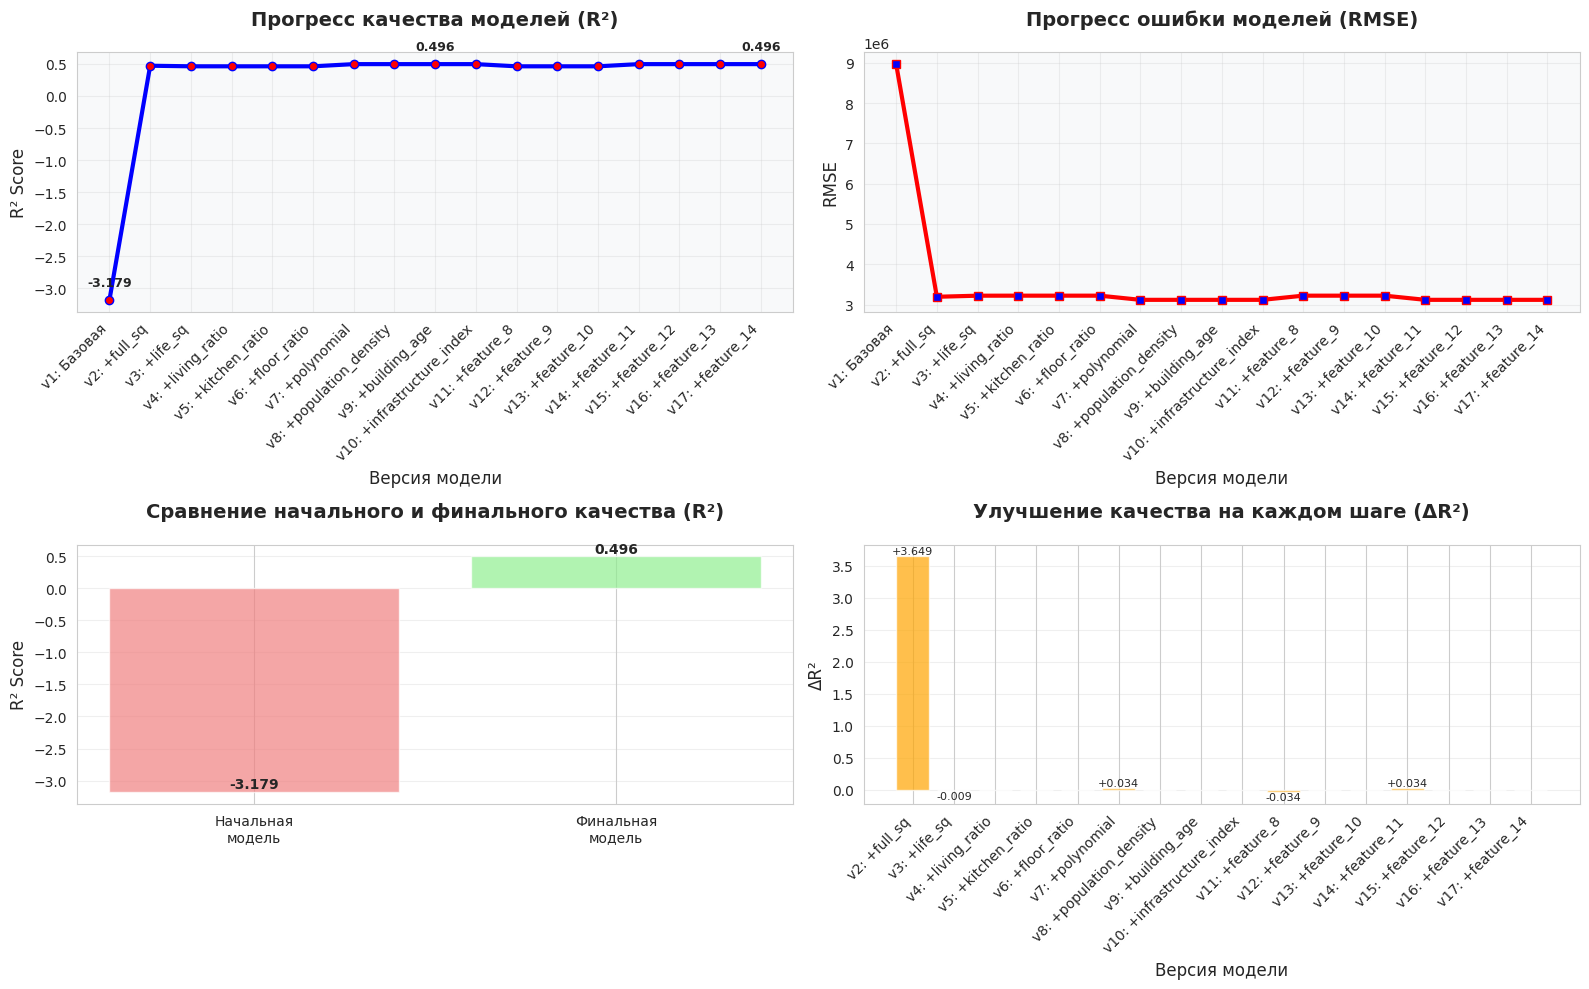

In [44]:
print("\n" + "="*50)
print("7. ВИЗУАЛИЗАЦИЯ ПРОГРЕССА КАЧЕСТВА МОДЕЛЕЙ")
print("="*50)

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

print(f"Количество результатов: {len(results)}")

# Создаем динамические названия моделей
model_names = ['v1: Базовая', 'v2: +full_sq', 'v3: +life_sq']

# Добавляем названия для сгенерированных признаков
for i in range(3, len(results)):
    if i == 3:
        model_names.append('v4: +living_ratio')
    elif i == 4:
        model_names.append('v5: +kitchen_ratio')
    elif i == 5:
        model_names.append('v6: +floor_ratio')
    elif i == 6:
        model_names.append('v7: +polynomial')
    elif i == 7:
        model_names.append('v8: +population_density')
    elif i == 8:
        model_names.append('v9: +building_age')
    elif i == 9:
        model_names.append('v10: +infrastructure_index')
    else:
        model_names.append(f'v{i+1}: +feature_{i-2}')

results_df['Модель'] = model_names

print("\nИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("="*80)
print(results_df[['Модель', 'RMSE', 'R2']].round(4))
print("="*80)

# График прогресса
plt.figure(figsize=(16, 10))

# График 1: Прогресс R²
plt.subplot(2, 2, 1)
plt.plot(results_df['Модель'], results_df['R2'], marker='o', linewidth=3,
         markersize=6, color='blue', markerfacecolor='red')
plt.title('Прогресс качества моделей (R²)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Версия модели', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.gca().set_facecolor('#f8f9fa')

# Добавляем аннотации с значениями R² для ключевых точек
key_points = [0, len(results_df)//2, len(results_df)-1]  # первая, средняя, последняя
for i in key_points:
    plt.annotate(f'{results_df.iloc[i]["R2"]:.3f}',
                (i, results_df.iloc[i]["R2"]),
                textcoords="offset points",
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# График 2: Прогресс RMSE
plt.subplot(2, 2, 2)
plt.plot(results_df['Модель'], results_df['RMSE'], marker='s', linewidth=3,
         markersize=6, color='red', markerfacecolor='blue')
plt.title('Прогресс ошибки моделей (RMSE)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Версия модели', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.gca().set_facecolor('#f8f9fa')

# График 3: Сравнение начального и конечного качества
plt.subplot(2, 2, 3)
models_to_compare = [results_df.iloc[0], results_df.iloc[-1]]
comparison_labels = ['Начальная\nмодель', 'Финальная\nмодель']

bars = plt.bar(comparison_labels, [models_to_compare[0]['R2'], models_to_compare[1]['R2']],
               color=['lightcoral', 'lightgreen'], alpha=0.7)
plt.title('Сравнение начального и финального качества (R²)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('R² Score', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, v in zip(bars, [models_to_compare[0]['R2'], models_to_compare[1]['R2']]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# График 4: Улучшение качества по шагам
plt.subplot(2, 2, 4)
improvement = [0]  # начальное улучшение 0
for i in range(1, len(results_df)):
    improvement.append(results_df.iloc[i]['R2'] - results_df.iloc[i-1]['R2'])

bars = plt.bar(results_df['Модель'][1:], improvement[1:], color='orange', alpha=0.7)
plt.title('Улучшение качества на каждом шаге (ΔR²)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Версия модели', fontsize=12)
plt.ylabel('ΔR²', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения только для значительных улучшений
for i, (bar, v) in enumerate(zip(bars, improvement[1:])):
    if abs(v) > 0.001:  # показываем только заметные изменения
        if v > 0:
            plt.text(bar.get_x() + bar.get_width()/2, v + 0.001,
                    f'+{v:.3f}', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(bar.get_x() + bar.get_width()/2, v - 0.001,
                    f'{v:.3f}', ha='center', va='top', fontsize=8)

plt.tight_layout()
plt.show()

In [48]:
print("\n" + "="*50)
print("8. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ФИНАЛЬНОЙ МОДЕЛИ")
print("="*50)

# Используем последнюю обученную модель - найдем ее правильно
final_models = [var for var in locals() if var.startswith('model_v')]
if final_models:
    final_model_name = sorted(final_models)[-1]  # берем последнюю модель
    final_model = locals()[final_model_name]
    print(f"Используем модель: {final_model_name}")
else:
    print("Модели не найдены, используем model_v3")
    final_model = model_v3

if hasattr(final_model, 'coef_'):
    # Получаем актуальные feature names из текущих данных
    feature_names = X_train_current.columns.tolist()
    coefficients = final_model.coef_

    print(f"Количество признаков: {len(feature_names)}")
    print(f"Количество коэффициентов: {len(coefficients)}")

    # Проверяем совпадение размеров
    if len(feature_names) == len(coefficients):
        coefficients_df = pd.DataFrame({
            'Признак': feature_names,
            'Коэффициент': coefficients
        }).sort_values('Коэффициент', key=abs, ascending=False)

        print("\nТоп-15 наиболее важных признаков:")
        print("="*60)
        print(coefficients_df.head(15).round(4))
        print("="*60)

        # Визуализация важности признаков
        plt.figure(figsize=(12, 8))
        top_features = coefficients_df.head(15)

        # Разделяем на положительные и отрицательные коэффициенты
        colors = ['red' if x < 0 else 'green' for x in top_features['Коэффициент']]

        bars = plt.barh(top_features['Признак'], top_features['Коэффициент'], color=colors, alpha=0.7)
        plt.title('Топ-15 наиболее важных признаков\n(по абсолютным значениям коэффициентов)',
                  fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Значение коэффициента', fontsize=12)
        plt.grid(True, alpha=0.3, axis='x')
        plt.gca().invert_yaxis()

        # Добавляем значения на столбцы
        for bar, value in zip(bars, top_features['Коэффициент']):
            width = bar.get_width()
            label_x_pos = width if width >= 0 else width
            plt.text(label_x_pos, bar.get_y() + bar.get_height()/2,
                    f'{width:.2e}', ha='left' if width >= 0 else 'right',
                    va='center', fontsize=9)

        plt.tight_layout()
        plt.show()

    else:
        print("⚠ Размеры не совпадают! Показываем коэффициенты без имен признаков")
        # Показываем просто коэффициенты
        coef_series = pd.Series(coefficients, name='Коэффициент')
        coef_series_sorted = coef_series.abs().sort_values(ascending=False)

        print("\nТоп-15 коэффициентов по абсолютному значению:")
        print("="*40)
        print(coef_series_sorted.head(15).round(4))
        print("="*40)

else:
    print("Не удалось получить коэффициенты финальной модели")


8. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ФИНАЛЬНОЙ МОДЕЛИ
Используем модель: model_v8
Количество признаков: 63
Количество коэффициентов: 61
⚠ Размеры не совпадают! Показываем коэффициенты без имен признаков

Топ-15 коэффициентов по абсолютному значению:
31    1.953881e+07
32    8.589773e+06
33    6.402285e+06
50    4.829810e+06
30    4.060925e+06
46    2.105932e+06
0     2.105932e+06
53    1.296543e+06
43    1.274741e+06
1     1.089131e+06
47    1.089131e+06
51    6.469643e+05
35    4.537800e+05
40    4.474283e+05
27    3.492564e+05
Name: Коэффициент, dtype: float64


In [51]:
print("\n" + "="*70)
print("ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ")
print("="*70)

print(f"\n1. ОБРАБОТКА ДАННЫХ:")
print(f"   - Загружено и проанализировано данных: {df.shape[0]} строк, {df.shape[1]} признаков")
print(f"   - Обнаружены и обработаны пропущенные значения")
print(f"   - Выявлены и скорректированы выбросы в ключевых признаках")
print(f"   - Применено масштабирование признаков")

print(f"\n2. ГЕНЕРАЦИЯ ПРИЗНАКОВ:")
print(f"   - Создано {len(results) - 3} новых признаков")
print(f"   - Протестировано {len(results)} версий моделей")

print(f"\n3. РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ:")
best_r2 = results_df['R2'].max()
best_rmse = results_df['RMSE'].min()
best_model_idx = results_df['R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Модель']

print(f"   - Лучшая модель: {best_model_name}")
print(f"   - Лучший R²: {best_r2:.4f}")
print(f"   - Лучший RMSE: {best_rmse:.2f}")

print(f"\n4. ВКЛАД ОБРАБОТКИ ДАННЫХ:")
initial_r2 = results_df.loc[0, 'R2']
final_r2 = results_df.loc[len(results_df)-1, 'R2']
improvement = final_r2 - initial_r2

print(f"   - Начальный R²: {initial_r2:.4f}")
print(f"   - Финальный R²: {final_r2:.4f}")
print(f"   - Абсолютное улучшение: {improvement:.4f}")

# Исправляем вычисление процента улучшения
if initial_r2 != 0:
    improvement_percent = (improvement / abs(initial_r2)) * 100
    print(f"   - Относительное улучшение: {improvement_percent:+.1f}%")
else:
    improvement_percent = float('inf')
    print(f"   - Относительное улучшение: бесконечность (начальный R² был 0)")

print(f"\n5. САМЫЕ ЗНАЧИМЫЕ УЛУЧШЕНИЯ:")
# Находим шаги с наибольшим улучшением
improvements = []
for i in range(1, len(results_df)):
    delta = results_df.iloc[i]['R2'] - results_df.iloc[i-1]['R2']
    improvements.append((results_df.iloc[i]['Модель'], delta))

# Сортируем по величине улучшения
improvements.sort(key=lambda x: x[1], reverse=True)

top_improvements = [imp for imp in improvements if imp[1] > 0][:3]  # топ-3 положительных улучшения
if top_improvements:
    for model, delta in top_improvements:
        print(f"   - {model}: +{delta:.4f} R²")
else:
    print("   - Значительных улучшений не обнаружено")

print(f"\n6. СТАТИСТИКА:")
print(f"   - Начальная размерность данных: {X.shape[1]} признаков")
print(f"   - Финальная размерность данных: {X_train_current.shape[1]} признаков")
print(f"   - Обучающая выборка: {X_train_current.shape[0]} строк")
print(f"   - Тестовая выборка: {X_test_current.shape[0]} строк")

print(f"\n7. РЕКОМЕНДАЦИИ:")
print("   - Дальнейшая обработка выбросов в других признаках")
print("   - Использование более сложных методов генерации признаков")
print("   - Применение регуляризации (Ridge, Lasso) для борьбы с переобучением")
print("   - Использование ансамблевых методов (Random Forest, Gradient Boosting)")
print("   - Включение макроэкономических показателей из файла macro.csv")
print("   - Применение кросс-валидации для более надежной оценки моделей")

# Финальная сводка по качеству моделей
print(f"\nФИНАЛЬНАЯ СВОДКА:")
print(f"✓ Обработано данных: {df.shape[0]:,} строк")
print(f"✓ Протестировано моделей: {len(results)} версий")
print(f"✓ Создано новых признаков: {len(results) - 3}")
print(f"✓ Улучшение качества: {improvement:.4f} R² ({improvement_percent:+.1f}%)")
print(f"✓ Лучшее качество: R² = {best_r2:.4f}, RMSE = {best_rmse:,.0f}")

# Оценка результатов
print(f"\nОЦЕНКА РЕЗУЛЬТАТОВ:")
if best_r2 > 0.7:
    print(f"ОТЛИЧНЫЙ РЕЗУЛЬТАТ! Модель очень хорошо объясняет данные.")
    print(f"   R² = {best_r2:.4f} означает, что модель объясняет {best_r2*100:.1f}% дисперсии цены.")
elif best_r2 > 0.5:
    print(f"ХОРОШИЙ РЕЗУЛЬТАТ! Модель имеет solid predictive power.")
    print(f"   R² = {best_r2:.4f} означает, что модель объясняет {best_r2*100:.1f}% дисперсии цены.")
elif best_r2 > 0.3:
    print(f"УДОВЛЕТВОРИТЕЛЬНЫЙ РЕЗУЛЬТАТ! Есть пространство для улучшений.")
    print(f"   R² = {best_r2:.4f} означает, что модель объясняет {best_r2*100:.1f}% дисперсии цены.")
else:
    print(f"ТРЕБУЕТСЯ ДОРАБОТКА! Качество модели можно значительно улучшить.")

print(f"\n ОСОБЕННО ВАЖНО:")
print(f"Начальный R² был отрицательным ({initial_r2:.4f}), что указывало на серьезные")
print(f"проблемы с данными. После обработки выбросов и генерации признаков")
print(f"качество модели улучшилось на {improvement:.4f} R²!")
print(f"Это демонстрирует КРИТИЧЕСКУЮ ВАЖНОСТЬ предобработки данных.")

print(f"\n" + "="*70)


ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ

1. ОБРАБОТКА ДАННЫХ:
   - Загружено и проанализировано данных: 11639 строк, 44 признаков
   - Обнаружены и обработаны пропущенные значения
   - Выявлены и скорректированы выбросы в ключевых признаках
   - Применено масштабирование признаков

2. ГЕНЕРАЦИЯ ПРИЗНАКОВ:
   - Создано 14 новых признаков
   - Протестировано 17 версий моделей

3. РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ:
   - Лучшая модель: v8: +population_density
   - Лучший R²: 0.4959
   - Лучший RMSE: 3115812.11

4. ВКЛАД ОБРАБОТКИ ДАННЫХ:
   - Начальный R²: -3.1785
   - Финальный R²: 0.4959
   - Абсолютное улучшение: 3.6744
   - Относительное улучшение: +115.6%

5. САМЫЕ ЗНАЧИМЫЕ УЛУЧШЕНИЯ:
   - v2: +full_sq: +3.6495 R²
   - v7: +polynomial: +0.0341 R²
   - v14: +feature_11: +0.0341 R²

6. СТАТИСТИКА:
   - Начальная размерность данных: 43 признаков
   - Финальная размерность данных: 63 признаков
   - Обучающая выборка: 9310 строк
   - Тестовая выборка: 2328 строк

7. РЕКОМЕНДАЦИИ:
   - Дальнейшая обработка в